# Reinforcement Learning

# Contextual Bandits

The objective of this lab is to recommend contents (here movies) using **contextual bandits**.

The lab is graded.

## Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer

from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout
from scipy.stats import spearmanr

## Data

We work on a catalogue of 1037 movies available in 2015.

In [2]:
catalogue = pd.read_pickle('movie_database.pickle')

In [3]:
len(catalogue)

1037

In [4]:
catalogue.head()

,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster
0,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...",Won 1 Oscar. Another 15 wins & 18 nominations.,[USA],[Irvin Kershner],"[Action, Adventure, Fantasy]",[English],[PG],1980-06-20,Star Wars: Episode V - The Empire Strikes Back,tt0080684,8.8,79.0,290158751.0,799579.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,"[Kareem Abdul-Jabbar, Lloyd Bridges, Peter Gra...",Nominated for 1 Golden Globe. Another 2 wins &...,[USA],"[Jim Abrahams, David Zucker, Jerry Zucker]",[Comedy],[English],[PG],1980-07-02,Airplane!,tt0080339,7.8,NaN,83400000.0,154994.0,88.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,"[John Belushi, Dan Aykroyd, James Brown, Cab C...",1 win.,[USA],[John Landis],"[Action, Comedy, Crime]",[English],[R],1980-06-20,The Blues Brothers,tt0080455,7.9,NaN,54200000.0,138196.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,"[Jack Nicholson, Shelley Duvall, Danny Lloyd, ...",3 wins & 5 nominations.,"[USA, UK]",[Stanley Kubrick],"[Drama, Horror]",[English],[R],1980-05-23,The Shining,tt0081505,8.4,61.0,NaN,584323.0,146.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,"[Anthony Hopkins, John Hurt, Anne Bancroft, Jo...",Nominated for 8 Oscars. Another 10 wins & 14 n...,"[USA, UK]",[David Lynch],"[Biography, Drama]",[English],[PG],1980-10-10,The Elephant Man,tt0080678,8.2,NaN,NaN,156572.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


The features are the following:

|Column|Description|Type|
|:---|:---|:---|
|Actors| Actors staring | list of strings|
|Awards| Awards received| string|
|Country| Country of origin| list of strings|
|Director| Director(s) of the movie|  list of strings|
|Genre| Genres (Action, ...) | list of strings|
|Language| Language(s) spoken |list of strings|
|Rated| Public rating (G = General, R = Restricted, ...)| list of strings|
|Released| Date of the movie| date|
|Title|Title of the movie|string|
|imdbID| IMDB id| string|
|imdbRating| IMDB rating (between 0 and 10)| float|
|Metascore| Metacritic score (between 0 and 100)|float|
|Box_office| Total money generated|float|
|imdbVotes| Number of IMDB votes| float|
|Runtime| Duration of the movie (in minutes)|float|
|poster| Poster of the movie (jpg)| binary string|

In [5]:
# Display the posters

def get_poster(k, scale=1):
    return Image(
        value = catalogue.loc[k].poster,
        format = 'jpg',
        width = 130 * scale,
        height = 200 * scale,
    )

def display_posters(index=None, n_col=5, n_rows=4):
    if index is None:
        index = np.arange(len(catalogue))
    if len(index):
        n_rows = min(n_rows, int(np.ceil(len(index) / n_col)))
        grid = GridspecLayout(n_rows, n_col)
        k = 0
        for i in range(n_rows):
            for j in range(n_col):
                if k < len(index):
                    grid[i, j] = get_poster(index[k])
                k += 1
        return grid

In [6]:
display_posters()

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Features

We will describe each movie by some features, for instance its genre.

In [7]:
mlb = MultiLabelBinarizer()

In [8]:
movies = pd.DataFrame(mlb.fit_transform(catalogue['Genre']), columns=mlb.classes_)

In [9]:
movies.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
movies.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'],
      dtype='object')

## Context

Each user will be modeled by a vector of weights (positive or negative) on each feature.

In [11]:
context = pd.DataFrame(0, index = [0], columns=movies.columns)
context['Action'] = 2
context['Crime'] = 1
context['Sci-Fi'] = -2

In [12]:
context

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-2,0,0,0,0


### To do

1. Display the favorite movies of this user.
2. Test another user, and quantify their similarity (e.g., proportion of common top-100 movies).

1. Display the favorite movies of this user.

In [13]:
movies_score = movies.dot(context.T)[0]
movies_score.name = 'Score'

user_favorite_movies = catalogue.merge(movies_score, left_index=True, right_index=True).sort_values('Score', ascending=False)[['Title', 'Genre', 'Score']]
top_n_movies = 20
print('User 1 top {} favorite movies:'.format(top_n_movies))
user_favorite_movies.head(top_n_movies)

User 1 top 20 favorite movies:


,Title,Genre,Score
895,Man on a Ledge,"[Action, Crime, Thriller]",3
856,21 Jump Street,"[Action, Comedy, Crime]",3
935,2 Guns,"[Action, Comedy, Crime]",3
329,Austin Powers in Goldmember,"[Action, Comedy, Crime]",3
451,The Punisher,"[Action, Crime, Drama]",3
85,Lethal Weapon 3,"[Action, Crime, Thriller]",3
736,Salt,"[Action, Crime, Mystery]",3
735,The Other Guys,"[Action, Comedy, Crime]",3
81,Point Break,"[Action, Crime, Thriller]",3
985,The Equalizer,"[Action, Crime, Thriller]",3


2. Test another user, and quantify their similarity (e.g., proportion of common top-100 movies).

In [14]:
context2 = pd.DataFrame(0, index = [0], columns=movies.columns)
context2['Action'] = 1
context2['Comedy'] = 2
context2['Drama'] = 2
context2['Horror'] = -2
context2['Thriller'] = -1
context2

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,0,0,0,2,0,0,2,0,0,...,-2,0,0,0,0,0,0,-1,0,0


In [15]:
movies_score2 = movies.dot(context2.T)[0]
movies_score2.name = 'Score'

user2_favorite_movies = catalogue.merge(movies_score2, left_index=True, right_index=True).sort_values('Score', ascending=False)[['Title', 'Genre', 'Score']]
top_n_movies = 20
print('User 2 top {} favorite movies:'.format(top_n_movies))
user2_favorite_movies.head(20)

User 2 top 20 favorite movies:


,Title,Genre,Score
716,3 Idiots,"[Comedy, Drama]",4
803,The Descendants,"[Comedy, Drama]",4
280,Almost Famous,"[Adventure, Comedy, Drama]",4
454,The Life Aquatic with Steve Zissou,"[Adventure, Comedy, Drama]",4
282,High Fidelity,"[Comedy, Drama, Music]",4
453,Garden State,"[Comedy, Drama, Romance]",4
710,Adventureland,"[Comedy, Drama, Romance]",4
56,When Harry Met Sally...,"[Comedy, Drama, Romance]",4
55,Dead Poets Society,"[Comedy, Drama]",4
525,Little Miss Sunshine,"[Comedy, Drama]",4


In [16]:
n_movies = 100
user_favorite_movies_set = set(user_favorite_movies.head(n_movies).index)
user2_favorite_movies_set = set(user2_favorite_movies.head(n_movies).index)

common_movies = user_favorite_movies_set.intersection(user2_favorite_movies_set)
print('There are {} movies in common among the top {} movies of the two users, which represents {}% of the top {} movies of each user.'.format(len(common_movies), n_movies, round(100 * len(common_movies) / n_movies), n_movies))

There are 11 movies in common among the top 100 movies of the two users, which represents 11% of the top 100 movies of each user.


## Offline learning

We start with offline learning. There are 2 steps:
* Collect the user's opinion on a few movies (e.g., 10)
* Rank the other movies by logistic regression.

Let's test that.

In [17]:
# Add a column to record the user's opinion (like / dislike)
movies = movies.assign(like=None)

In [18]:
# Select a random movie (not yet seen by the user)
def select_random_movie():
    index = np.flatnonzero(movies.like.isna())
    if len(index):
        return np.random.choice(index)
    else:
        return np.random.choice(len(movies))

In [19]:
# Create buttons
def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout())

def update_likes(button):
    global movie_id
    movies.loc[movie_id, 'like'] = button.description == 'like'

def update_poster():
    global movie_id
    img.value = catalogue.loc[movie_id].poster

def on_button_clicked(button):
    global movie_id
    update_likes(button)
    movie_id = select_random_movie()
    update_poster()

In [20]:
# Setting the buttons
left_button = create_expanded_button('like', 'success')
right_button = create_expanded_button('dislike', 'danger')
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# Setting the movie poster
movie_id = select_random_movie()
img = get_poster(movie_id, scale=1.5)

# Display
AppLayout(
    left_sidebar=left_button,
    right_sidebar=right_button,
    center=img,
    pane_widths=[0.3, 0.4, 0.3]
)

AppLayout(children=(Button(button_style='success', description='like', layout=Layout(grid_area='left-sidebar')…

### To do

1. Give your opinion on some movies (e.g., 10), making sure that you get a few likes and a few dislikes.
2. Apply logistic regression and display the other movies in order of preference (top movies first).
3. Give your top-3 and bottom-3 genres, as predicted by the model.

1. Give your opinion on some movies (e.g., 10), making sure that you get a few likes and a few dislikes.

In [21]:
# likes
likes = np.flatnonzero(movies.like==True)
display_posters(likes)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [22]:
# dislikes
dislikes = np.flatnonzero(movies.like==False)
display_posters(dislikes)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

2. Apply logistic regression and display the other movies in order of preference (top movies first).

In [23]:
# Remove the liked and disliked movies from the dataframe movies
movies_noreview = movies.copy()
movies_noreview.drop(likes, axis=0, inplace=True)
movies_noreview.drop(dislikes, axis=0, inplace=True)

# Drop the lines without review
movies_review = movies.copy()
movies_review.dropna(subset=['like'], inplace=True)

# Define the training and testing set
X_train, y_train = movies_review.iloc[:, :-1].values, movies_review.iloc[:, -1].values.astype('int')
X_test =  movies_noreview.iloc[:, :-1].values

In [24]:
# Define the model, fit and predict
model = LogisticRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_predict_proba = model.predict_proba(X_test)

In [25]:
# Display the predicted movies by order of preference
prob_likes = y_predict_proba[:,1]
movies_noreview['like'] = prob_likes
movies_noreview.rename(columns={'like': 'Prefered probability'}, inplace=True)

print('Prefered movies obtained by Logistic Regression')
movies_log_reg = catalogue.merge(movies_noreview, left_index=True, right_index=True)    # Merge with catalog to obtain information
movies_log_reg.sort_values('Prefered probability', ascending=False, inplace=True)       # Sort according to prefered movies
movies_log_reg = movies_log_reg.loc[:, ['Title', 'Genre', 'Prefered probability']]      # Show only important information
movies_log_reg

Prefered movies obtained by Logistic Regression


,Title,Genre,Prefered probability
223,Austin Powers: The Spy Who Shagged Me,"[Action, Adventure, Comedy]",0.783359
239,Galaxy Quest,"[Adventure, Comedy, Sci-Fi]",0.783359
265,Charlie's Angels,"[Action, Adventure, Comedy]",0.783359
203,The Mask of Zorro,"[Action, Adventure, Comedy]",0.783359
678,Night at the Museum: Battle of the Smithsonian,"[Action, Adventure, Comedy]",0.783359
...,...,...,...
636,21,"[Crime, Drama, Thriller]",0.159178
400,Matchstick Men,"[Crime, Drama, Thriller]",0.159178
77,The Silence of the Lambs,"[Crime, Drama, Thriller]",0.159178
154,Sleepers,"[Crime, Drama, Thriller]",0.159178


3. Give your top-3 and bottom-3 genres, as predicted by the model.

In [26]:
# Get the most important coefficients
coeff = model.coef_

top3_genres = np.argsort(coeff)[0][::-1][:3]
top3_genres_names = movies_noreview.columns[top3_genres]
top3_genres_coeff = coeff[0][top3_genres]

bot3_genres = np.argsort(coeff)[0][:3]
bot3_genres_names = movies_noreview.columns[bot3_genres]
bot3_genres_coeff = coeff[0][bot3_genres]

print('The top 3 genres are: {}, {} and {}'.format(top3_genres_names[0], top3_genres_names[1], top3_genres_names[2]))
print('The associated top 3 coefficients are respectively: {:.3f}, {:.3f} and {:.3f}'.format(top3_genres_coeff[0], top3_genres_coeff[1], top3_genres_coeff[2]))
print('The bottom 3 genres are: {}, {} and {}'.format(bot3_genres_names[0], bot3_genres_names[1], bot3_genres_names[2]))
print('The associated bottom 3 coefficients are respectively: {:.3f}, {:.3f} and {:.3f}'.format(bot3_genres_coeff[0], bot3_genres_coeff[1], bot3_genres_coeff[2]))

The top 3 genres are: Comedy, Adventure and Action
The associated top 3 coefficients are respectively: 0.531, 0.489 and 0.265
The bottom 3 genres are: Drama, Thriller and Romance
The associated bottom 3 coefficients are respectively: -0.817, -0.660 and -0.506


## Online learning

We now learn the user preferences online, as they come. For that, we use a Bayesian algorithm inspired by Thompson sampling.

On each feedback provided by the user:
1. (Learning) The context is learned, using logistic regression.
2. (Sampling) A new context is sampled, assuming a Gaussian distribution.
3. (Action) The top movie for this new context, among movies not yet seen by the user, is proposed.

Note that:
* In step 1, we retrain the estimator **from scratch**, using all training data samples (**no** online estimation).
* In step 2, we discard correlations (**diagonal** covariance matrix).

### To do

1. Complete the function ``select_bayes`` below.
2. Test it on some movies (e.g., 10), until you get a few likes and a few dislikes.
3. Display the other movies in order of preference (top movies first).

1. Complete the function ``select_bayes`` below.

In [27]:
def select_bayes(movies=movies):
    if set(movies.like) == {True, False, None}:
        ### Learning --------------------------------------------------------------------------------
        C = 1
        lambda_regularization = 1/C
        model = LogisticRegression(fit_intercept=False, C=C)
        likes = np.flatnonzero(movies.like==True)
        dislikes = np.flatnonzero(movies.like==False)

        movies_noreview = movies.copy()
        movies_noreview.drop(likes, axis=0, inplace=True)
        movies_noreview.drop(dislikes, axis=0, inplace=True)

        # Drop the lines without review
        movies_review = movies.copy()
        movies_review.dropna(subset=['like'], inplace=True)

        # Define the training and testing set
        X_train, y_train = movies_review.iloc[:, :-1].values, movies_review.iloc[:, -1].values.astype('int')
        X_test =  movies_noreview.iloc[:, :-1].values

        model.fit(X_train, y_train)
        y_predict_proba = model.predict_proba(X_train)
        # p_s * (1-p_s):
        proba_multiplication = np.prod(y_predict_proba, axis=1)

        # Since the elements of the array of actions are 0 or 1, the square of the array is equal to the array itself
        proba_multiplication_a2 = X_train * proba_multiplication.reshape(-1,1)
        proba_multiplication_a2_sum = proba_multiplication_a2.sum(axis=0)
        proba_multiplication_a2_sum = X_train.sum(axis=0)

        ### Sampling --------------------------------------------------------------------------------
        mean = model.coef_[0]                       # most likely coefficient values
        lambda_array = lambda_regularization * np.ones(len(mean),)
        covariance_matrix = np.diag(1 / (lambda_array + proba_multiplication_a2_sum))
        sample = np.random.multivariate_normal(mean, covariance_matrix)

        ### Action --------------------------------------------------------------------------------
        action = np.argmax(X_test @ sample)
        action_original_index = movies_noreview.iloc[[action]].index.values[0]

        return action_original_index

    else:
        return select_random_movie()

2. Test it on some movies (e.g., 10), until you get a few likes and a few dislikes.

In [28]:
# reset
movies = movies.assign(like=None)

In [29]:
def on_button_clicked(button):
    global movie_id
    update_likes(button)
    movie_id = select_bayes()
    update_poster()

In [30]:
# Setting the buttons
left_button = create_expanded_button('like', 'success')
right_button = create_expanded_button('dislike', 'danger')
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# Setting the movie poster
movie_id = select_random_movie()
img = get_poster(movie_id, scale=1.5)

# Display
AppLayout(
    left_sidebar=left_button,
    right_sidebar=right_button,
    center=img,
    pane_widths=[0.3, 0.4, 0.3]
)

AppLayout(children=(Button(button_style='success', description='like', layout=Layout(grid_area='left-sidebar')…

3. Display the other movies in order of preference (top movies first).

In [31]:
likes = np.flatnonzero(movies.like==True)
dislikes = np.flatnonzero(movies.like==False)

movies_noreview = movies.copy()                             # movies selected online
movies_noreview.drop(likes, axis=0, inplace=True)
movies_noreview.drop(dislikes, axis=0, inplace=True)

# Drop the lines without review
movies_review = movies.copy()
movies_review.dropna(subset=['like'], inplace=True)

# Define the training and testing set
X_train, y_train = movies_review.iloc[:, :-1].values, movies_review.iloc[:, -1].values.astype('int')
X_test =  movies_noreview.iloc[:, :-1].values

model.fit(X_train, y_train)
y_predict_prob = model.predict_proba(X_test)

In [32]:
# Display the other movies by order of preference
prob_likes = y_predict_prob[:,1]
movies_noreview['like'] = prob_likes
movies_noreview.rename(columns={'like': 'Prefered probability'}, inplace=True)

print('Prefered movies obtained by Logistic Regression')
movies_log_reg = catalogue.merge(movies_noreview, left_index=True, right_index=True)    # Merge with catalog to obtain information
movies_log_reg.sort_values('Prefered probability', ascending=False, inplace=True)       # Sort according to prefered movies
movies_log_reg = movies_log_reg.loc[:, ['Title', 'Genre', 'Prefered probability']]      # Show only important information
movies_log_reg

Prefered movies obtained by Logistic Regression


,Title,Genre,Prefered probability
42,Who Framed Roger Rabbit,"[Animation, Comedy, Crime]",0.762462
748,RED,"[Action, Comedy, Crime]",0.744238
948,RED 2,"[Action, Comedy, Crime]",0.744238
975,22 Jump Street,"[Action, Comedy, Crime]",0.744238
137,Bad Boys,"[Action, Comedy, Crime]",0.744238
...,...,...,...
691,Knowing,"[Drama, Mystery, Sci-Fi]",0.352569
338,The Ring,"[Horror, Mystery, Sci-Fi]",0.352569
271,Unbreakable,"[Drama, Mystery, Sci-Fi]",0.352569
1036,Ex Machina,"[Drama, Mystery, Sci-Fi]",0.352569


## Analysis

Finally, we would like to assess the quality of our bandit algorithm.

### To do

1. Choose a user, that is a ground-truth context $\theta$ (= vector of weights).

2. Provide the answers of this user to the movies proposed by the algorithm, assuming binary rewards, with mean
$$
q(a) = \frac 1 {1 + e^{-\theta^T a}},
$$
where $a$ is the action (= movie proposed by the algorithm).

3. Make sure that a reasonable fraction of movies are liked (e.g., between 10\% and 90\%). Otherwise, update $\theta$.

4. Simulate an interaction of this user with the recommender system over 100 movies.

5. Compute the [Spearman's correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) of the ranking of the unseen movies provided by the algorithm, compared to the ground-truth ranking.

6. Plot the evolution of this coefficient with respect to the number of movies seen by the user, from 1 to 100.

7. Give the top-3 and bottom-3 genres, as predicted by the model, and compare to the ground-truth.

8. Do the same experiments with other features (e.g., actors, actors + genres, actors + director + genres).

1. Choose a user, that is a ground-truth context $\theta$ (= vector of weights).

In [33]:
# Choose an user
context = pd.DataFrame(0, index = [0], columns=movies.columns)
context.drop(columns=['like'], inplace=True)
context['Action'] = 0
context['Adventure'] = 0.5
context['Animation'] = -0.5
context['Biography'] = 1.5
context['Comedy'] = 2
context['Crime'] = 0.5
context['Documentary'] = -0.5
context['Drama'] = 1.25
context['Family'] = 0
context['Fantasy'] = -0.5
context['History'] = 0.5
context['Horror'] = -2
context['Music'] = 0
context['Musical'] = -1.5
context['Mystery'] = 0.5
context['Romance'] = 1
context['Sci-Fi'] = -1
context['Sport'] = 0
context['Thriller'] = -0.5
context['War'] = -0.5
context['Western'] = -0.5
context

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0.5,-0.5,1.5,2,0.5,-0.5,1.25,0,-0.5,...,-2,0,-1.5,0.5,1,-1,0,-0.5,-0.5,-0.5


2. Provide the answers of this user to the movies proposed by the algorithm, assuming binary rewards, with mean
$$
q(a) = \frac 1 {1 + e^{-\theta^T a}},
$$
where $a$ is the action (= movie proposed by the algorithm).

In [38]:
movies_ground_truth_prob = 1 / (1 + np.exp(-movies.drop(columns=['like']).dot(context.T)[0]))
movies_ground_truth_prob
pd.DataFrame({'Probability of like': movies_ground_truth_prob})

,Probability of like
0,0.500000
1,0.880797
2,0.924142
3,0.320821
4,0.939913
...,...
1032,0.851953
1033,0.924142
1034,0.962673
1035,0.377541


In [37]:
movies_ground_truth_like = movies_ground_truth_prob > 0.5
pd.DataFrame({'like': movies_ground_truth_like})

,like
0,False
1,True
2,True
3,False
4,True
...,...
1032,True
1033,True
1034,True
1035,False


3. Make sure that a reasonable fraction of movies are liked (e.g., between 10\% and 90\%). Otherwise, update $\theta$.

In [39]:
print('The share of movies liked by the user is {:.2f}%'.format(100 * movies_ground_truth_like.mean()))

The share of movies liked by the user is 67.41%


4. Simulate an interaction of this user with the recommender system over 100 movies.

In [44]:
# reset
movies = movies.assign(like=None)

In [45]:
n_movies = 100
for i in range(n_movies):
    movie_id = select_bayes()

    proposed_movie = movies.iloc[movie_id]
    context_scalar_movie = proposed_movie.drop('like').dot(context.T).values[0]
    proba = 1 / (1 + np.exp(-context_scalar_movie))
    opinion_user = np.random.binomial(1, p=proba) == 1
    movies.at[movie_id, 'like'] = bool(opinion_user)

liked_movies = np.flatnonzero(movies.like==True).shape[0]
disliked_movies = np.flatnonzero(movies.like==False).shape[0]
proportion_liked_movies = 100 * (liked_movies) / (liked_movies+disliked_movies)
print('The share of liked movies is {:.2f}%, which corresponds to {} movies'.format(proportion_liked_movies, liked_movies))

print('User feedback on {} proposed movies:'.format(n_movies))
likes = movies.like
likes.dropna(inplace=True)

movies_feedback = catalogue.merge(likes, left_index=True, right_index=True)    # Merge with catalog to obtain information
movies_feedback = movies_feedback.loc[:, ['Title', 'Genre', 'like']]             # Show only important information
movies_feedback

The share of liked movies is 69.77%, which corresponds to 30 movies
User feedback on 100 proposed movies:


,Title,Genre,like
9,Ghostbusters,"[Adventure, Comedy, Fantasy]",True
11,Gremlins,"[Comedy, Fantasy, Horror]",True
13,Amadeus,"[Biography, Drama, Music]",True
20,The Goonies,"[Adventure, Comedy, Family]",True
26,Aliens,"[Action, Horror, Sci-Fi]",True
42,Who Framed Roger Rabbit,"[Animation, Comedy, Crime]",True
57,The Little Mermaid,"[Animation, Family, Fantasy]",False
67,Back to the Future Part III,"[Comedy, Sci-Fi, Western]",False
82,Aladdin,"[Animation, Adventure, Comedy]",True
87,Wayne's World,"[Comedy, Music]",False


5. Compute the [Spearman's correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) of the ranking of the unseen movies provided by the algorithm, compared to the ground-truth ranking.

In [46]:
likes = np.flatnonzero(movies.like==True)
dislikes = np.flatnonzero(movies.like==False)  

movies_noreview = movies.copy()                             # movies selected online
movies_noreview.drop(likes, axis=0, inplace=True)
movies_noreview.drop(dislikes, axis=0, inplace=True)

# Drop the lines without review
movies_review = movies.copy()
movies_review.dropna(subset=['like'], inplace=True)

# Define the training and testing set
X_train, y_train = movies_review.iloc[:, :-1].values, movies_review.iloc[:, -1].values.astype('int')
X_test =  movies_noreview.iloc[:, :-1].values

model.fit(X_train, y_train)
y_predict_prob = model.predict_proba(X_test)

prob_likes = y_predict_prob[:,1]
movies_noreview['like'] = prob_likes
movies_noreview.rename(columns={'like': 'predicted_probability'}, inplace=True)

two_probs = pd.merge(movies_noreview['predicted_probability'], movies_ground_truth_prob, left_index=True, right_index=True)
two_probs.rename(columns={0: 'ground_truth_probability'}, inplace=True)

print('Spearman\'s correlation coefficient: {:.3f}'.format(spearmanr(two_probs.predicted_probability, two_probs.ground_truth_probability)[0]))

Spearman's correlation coefficient: 0.817


6. Plot the evolution of this coefficient with respect to the number of movies seen by the user, from 1 to 100.

In [47]:
# reset
movies = movies.assign(like=None)

In [48]:
spearmanr_list = []

n_movies = 100
for _ in range(n_movies):
    
    selected_movie = select_bayes()
    p = 1 / (1 + np.exp(-movies.iloc[selected_movie].drop('like').dot(context.T).values[0]))
    like = np.random.binomial(1, p)
    movies.at[selected_movie, 'like'] = bool(like)

    if set(movies.like) == {True, False, None}:    
        likes = np.flatnonzero(movies.like==True)
        dislikes = np.flatnonzero(movies.like==False)  

        movies_noreview = movies.copy()                             # movies selected online
        movies_noreview.drop(likes, axis=0, inplace=True)
        movies_noreview.drop(dislikes, axis=0, inplace=True)

        # Drop the lines without review
        movies_review = movies.copy()
        movies_review.dropna(subset=['like'], inplace=True)

        # Define the training and testing set
        X_train, y_train = movies_review.iloc[:, :-1].values, movies_review.iloc[:, -1].values.astype('int')
        X_test =  movies_noreview.iloc[:, :-1].values

        model.fit(X_train, y_train)
        y_predict_prob = model.predict_proba(X_test)

        prob_likes = y_predict_prob[:,1]
        movies_noreview['like'] = prob_likes
        movies_noreview.rename(columns={'like': 'predicted_probability'}, inplace=True)

        two_probs = pd.merge(movies_noreview['predicted_probability'], movies_ground_truth_prob, left_index=True, right_index=True)
        two_probs.rename(columns={0: 'ground_truth_probability'}, inplace=True)

        spearmanr_list.append(spearmanr(two_probs['predicted_probability'], two_probs['ground_truth_probability'])[0])

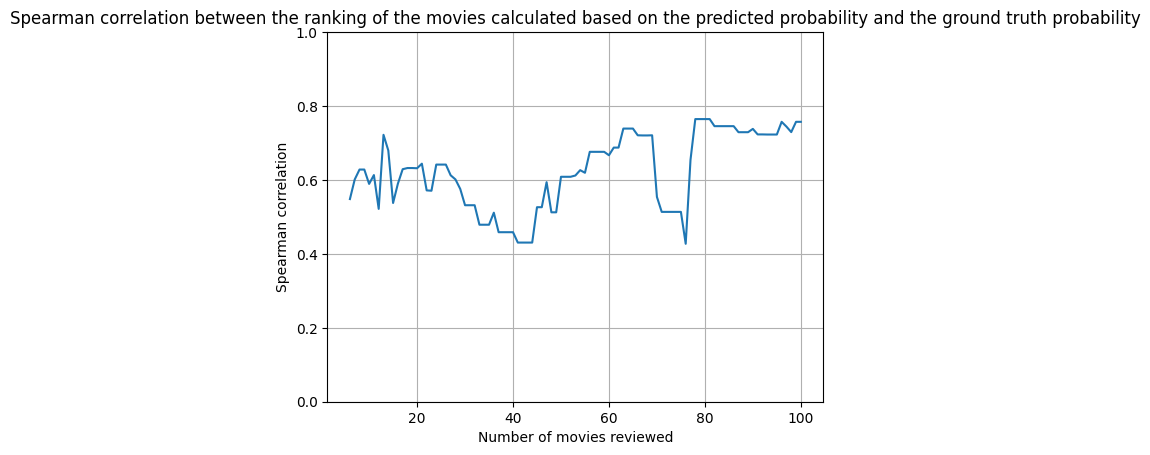

In [49]:
import matplotlib.pyplot as plt
plt.plot(range(n_movies - len(spearmanr_list) + 1, n_movies + 1), spearmanr_list)
plt.ylim(0, 1)
plt.xlabel('Number of movies reviewed')
plt.ylabel('Spearman correlation')
plt.title('Spearman correlation between the ranking of the movies calculated based on the predicted probability and the ground truth probability')
plt.grid()
plt.show()

7. Give the top-3 and bottom-3 genres, as predicted by the model, and compare to the ground-truth.

In [50]:
predicted_coefficients = model.coef_[0]
top3_predicted_genres = np.argsort(predicted_coefficients)[::-1][:3]
top3_predicted_genres_names = context.columns[top3_predicted_genres]
top3_predicted_genres_coefficients = predicted_coefficients[top3_predicted_genres]

bottom3_predicted_genres = np.argsort(predicted_coefficients)[:3]
bottom3_predicted_genres_names = context.columns[bottom3_predicted_genres]
bottom3_predicted_genres_coefficients = predicted_coefficients[bottom3_predicted_genres]

In [51]:
top3_ground_truth_genres = np.argsort(context.values[0])[::-1][:3]
top3_ground_truth_genres_names = context.columns[top3_ground_truth_genres]
top3_ground_truth_genres_coefficients = context.values[0][top3_ground_truth_genres]

bottom3_ground_truth_genres = np.argsort(context.values[0])[:3]
bottom3_ground_truth_genres_names = context.columns[bottom3_ground_truth_genres]
bottom3_ground_truth_genres_coefficients = context.values[0][bottom3_ground_truth_genres]

In [52]:
pd.DataFrame(
    {
        'Genres: top 3 predicted': top3_predicted_genres_names,
        'Coefficients: top 3 predicted': top3_predicted_genres_coefficients,
        'Genres: top 3 ground truth': top3_ground_truth_genres_names,
        'Coefficients: top 3 ground truth': top3_ground_truth_genres_coefficients,
        'Genres: bottom 3 predicted': bottom3_predicted_genres_names,
        'Coefficients: bottom 3 predicted': bottom3_predicted_genres_coefficients,
        'Genres: bottom 3 ground truth': bottom3_ground_truth_genres_names,
        'Coefficients: bottom 3 ground truth': bottom3_ground_truth_genres_coefficients,
    }
)

,Genres: top 3 predicted,Coefficients: top 3 predicted,Genres: top 3 ground truth,Coefficients: top 3 ground truth,Genres: bottom 3 predicted,Coefficients: bottom 3 predicted,Genres: bottom 3 ground truth,Coefficients: bottom 3 ground truth
0,Comedy,1.532186,Comedy,2.00,Horror,-0.892608,Horror,-2.0
1,Family,0.850325,Biography,1.50,Musical,-0.073769,Musical,-1.5
2,Biography,0.560939,Drama,1.25,War,-0.061979,Sci-Fi,-1.0


8. Do the same experiments with other features (e.g., actors, actors + genres, actors + director + genres).

Actors

In [53]:
actors = pd.DataFrame(mlb.fit_transform(catalogue['Actors']), columns=mlb.classes_)

context_actors = pd.DataFrame(0, index = [0], columns=actors.columns)
context_actors['Adam Sandler'] = 3
context_actors['Amara Karan'] = -1
context_actors['Bill Sage'] = 1
context_actors['Chris Stack'] = -2
context_actors['Beau Bridges'] = 1
context_actors

,A. Russell Andrews,A.J. Cook,Aamir Khan,Aaron Eckhart,Aaron Paul,Aaron Ruell,Aaron Stanford,Aaron Taylor-Johnson,Aaron Yoo,Aasif Mandvi,...,Zachary Quinto,Zachery Ty Bryan,Ziyi Zhang,Zoe Saldana,Zoe Salmon,Zoey Vargas,Zoltán Mucsi,Zooey Deschanel,Zoë Bell,Zoë Kravitz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
actors = actors.assign(like=None)

In [63]:
actors_ground_truth_prob = 1 / (1 + np.exp(-actors.drop(columns=['like']).dot(context_actors.T)[0]))
actors_ground_truth_like = actors_ground_truth_prob > 0.5
pd.DataFrame({'Probability of like': actors_ground_truth_prob, 'like': actors_ground_truth_like})

,Probability of like,like
0,0.5,False
1,0.5,False
2,0.5,False
3,0.5,False
4,0.5,False
...,...,...
1032,0.5,False
1033,0.5,False
1034,0.5,False
1035,0.5,False


In [62]:
n_movies = 100
for i in range(n_movies):
    movie_id = select_bayes(actors)

    proposed_movie = actors.iloc[movie_id]
    context_scalar_movie = proposed_movie.drop('like').dot(context_actors.T).values[0]
    proba = 1 / (1 + np.exp(-context_scalar_movie))
    opinion_user = np.random.binomial(1, p=proba)
    actors.at[movie_id, 'like'] = bool(opinion_user)

liked_movies = np.flatnonzero(actors.like==True).shape[0]
disliked_movies = np.flatnonzero(actors.like==False).shape[0]
proportion_liked_movies = 100 * (liked_movies) / (liked_movies+disliked_movies)
print('The share of liked movies is {:.2f}%, which corresponds to {} movies'.format(proportion_liked_movies, liked_movies))

print('User feedback on {} proposed movies:'.format(n_movies))
likes = actors.like
likes.dropna(inplace=True)

movies_feedback = catalogue.merge(likes, left_index=True, right_index=True)    # Merge with catalog to obtain information
movies_feedback = movies_feedback.loc[:, ['Title', 'Actors', 'like']]             # Show only important information
movies_feedback

The share of liked movies is 45.00%, which corresponds to 45 movies
User feedback on 100 proposed movies:


,Title,Actors,like
4,The Elephant Man,"[Anthony Hopkins, John Hurt, Anne Bancroft, Jo...",False
7,A Christmas Story,"[Melinda Dillon, Darren McGavin, Peter Billing...",True
12,The Karate Kid,"[Ralph Macchio, Pat Morita, Elisabeth Shue, Ma...",True
13,Amadeus,"[F. Murray Abraham, Tom Hulce, Elizabeth Berri...",True
39,Spaceballs,"[Mel Brooks, John Candy, Rick Moranis, Bill Pu...",False
...,...,...,...
1005,Whiplash,"[Miles Teller, J.K. Simmons, Paul Reiser, Meli...",False
1009,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",True
1021,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Nicholas Hoult, H...",False
1025,Maze Runner: The Scorch Trials,"[Dylan O'Brien, Ki Hong Lee, Kaya Scodelario, ...",False


Actors and Genres

In [93]:
actors = pd.DataFrame(mlb.fit_transform(catalogue['Actors']), columns=mlb.classes_)
actors_movies = pd.merge(actors, movies, left_index=True, right_index=True)

context_actors_movies = pd.DataFrame(0, index = [0], columns=actors_movies.columns)
context_actors_movies['Adam Sandler'] = 3
context_actors_movies['Amara Karan'] = -1
context_actors_movies['Bill Sage'] = 1
context_actors_movies['Chris Stack'] = -2
context_actors_movies['Beau Bridges'] = 1
context_actors_movies['Animation'] = -2
context_actors_movies['Adventure'] = 1
context_actors_movies['Romance'] = 3
context_actors_movies['Action'] = 1
context_actors_movies['Music'] = -3
context_actors_movies.drop(columns=['like'], inplace=True)
context_actors_movies

,A. Russell Andrews,A.J. Cook,Aamir Khan,Aaron Eckhart,Aaron Paul,Aaron Ruell,Aaron Stanford,Aaron Taylor-Johnson,Aaron Yoo,Aasif Mandvi,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,-3,0,0,3,0,0,0,0,0


In [94]:
actors_movies = actors_movies.assign(like=None)

In [96]:
actors_movies_ground_truth_prob = 1 / (1 + np.exp(-actors_movies.drop(columns=['like']).dot(context_actors_movies.T)[0]))
actors_movies_ground_truth_like = actors_movies_ground_truth_prob > 0.5
pd.DataFrame({'Probability of like': actors_movies_ground_truth_prob, 'like': actors_movies_ground_truth_like})

,Probability of like,like
0,0.880797,True
1,0.500000,False
2,0.731059,True
3,0.500000,False
4,0.500000,False
...,...,...
1032,0.731059,True
1033,0.880797,True
1034,0.500000,False
1035,0.731059,True


In [97]:
n_movies = 100
for i in range(n_movies):
    movie_id = select_bayes(actors_movies)

    proposed_movie = actors_movies.iloc[movie_id]
    context_scalar_movie = proposed_movie.drop('like').dot(context_actors_movies.T).values[0]
    proba = 1 / (1 + np.exp(-context_scalar_movie))
    opinion_user = np.random.binomial(1, p=proba)
    actors_movies.at[movie_id, 'like'] = bool(opinion_user)

liked_movies = np.flatnonzero(actors_movies.like==True).shape[0]
disliked_movies = np.flatnonzero(actors_movies.like==False).shape[0]
proportion_liked_movies = 100 * (liked_movies) / (liked_movies+disliked_movies)
print('The share of liked movies is {:.2f}%, which corresponds to {} movies'.format(proportion_liked_movies, liked_movies))

print('User feedback on {} proposed movies:'.format(n_movies))
likes = actors_movies.like
likes.dropna(inplace=True)

movies_feedback = catalogue.merge(likes, left_index=True, right_index=True)    # Merge with catalog to obtain information
movies_feedback = movies_feedback.loc[:, ['Title', 'Actors', 'Genre', 'like']]             # Show only important information
movies_feedback

The share of liked movies is 72.00%, which corresponds to 72 movies
User feedback on 100 proposed movies:


,Title,Actors,Genre,like
0,Star Wars: Episode V - The Empire Strikes Back,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...","[Action, Adventure, Fantasy]",True
12,The Karate Kid,"[Ralph Macchio, Pat Morita, Elisabeth Shue, Ma...","[Action, Drama, Family]",True
19,Rocky IV,"[Sylvester Stallone, Talia Shire, Burt Young, ...","[Drama, Sport]",True
28,Stand by Me,"[Wil Wheaton, River Phoenix, Corey Feldman, Je...","[Adventure, Drama]",True
33,Dirty Dancing,"[Jennifer Grey, Patrick Swayze, Jerry Orbach, ...","[Drama, Music, Romance]",True
...,...,...,...,...
1011,Inside Out,"[Amy Poehler, Phyllis Smith, Richard Kind, Bil...","[Animation, Adventure, Comedy]",False
1019,Fifty Shades of Grey,"[Dakota Johnson, Jamie Dornan, Jennifer Ehle, ...","[Drama, Romance]",True
1026,Ted 2,"[Mark Wahlberg, Seth MacFarlane, Amanda Seyfri...",[Comedy],True
1028,The Big Short,"[Ryan Gosling, Rudy Eisenzopf, Casey Groves, C...","[Biography, Comedy, Drama]",False
